<a href="https://colab.research.google.com/github/DesiPilla/CISC-181-Final-Coding-Project/blob/master/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 9

Name: Desiderio Pilla

Date: May 8th, 2020

# Overview

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in the light emission in 6 different bands. The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good riend Gautham Narayan in fact!) to get started and ingest and preprocess the PLASTiCC challenge data. However, this is written with a class (object oriented) and we have not talked about this syntax in class. If you are not familiar with classes do not worry about it (but you should learn them!). Also I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.



In [91]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
import pickle
import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way (i.e. that Yuqic an grade each notebook and the data will be accessed automatically without modifications to the code). You will need the training data and the metadata files


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/Colab Notebooks/MLTSA/plastic'

/content/drive/My Drive/Colab Notebooks/MLTSA/plastic


In [37]:
lcvs = pd.read_csv("training_set.csv")
lcvs = lcvs[:10000]
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (10000, 6)


In [38]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


For each object there are 6 time series in 6 different passbands (see overview.) 

In [39]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [40]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 31 astrophysical simulated objects in my dataset


# Gaussian Processing

In order to run the neural network, the inputs must all occur at the same time step. Because the data are not evenly sampled, I will use Gaussian Processing to generate a smooth curve of the data, and then take even samples from that distribution.

In [0]:
def make_gp(mjd, flux):
    '''This function uses Gaussian Processes to create an evenly sampled estimate
    of the time series'''

    # Standardize the data
    mjd_st = (mjd - mjd.mean()) / mjd.std()
    flux_st = (flux - flux.mean()) / flux.std()

    # Fit the Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=0.015)
    gpr.fit(mjd_st.reshape(-1, 1), flux_st)

    # Predict the flux for evenly spaced time samples 
    mjd_even_st = np.linspace((0 - mjd.mean()) / mjd.std(), (900 - mjd.mean()) / mjd.std())
    flux_even_st, sigma = gpr.predict(mjd_even_st.reshape(-1, 1), return_std=True)

    # Unstandardize evenly spaced data
    mjd_even = mjd_even_st * mjd.std() + mjd.mean()
    flux_even = flux_even_st * flux.std() + flux.mean()
    sigma = sigma * flux.std() + flux.mean()

    return mjd_even, flux_even

In [104]:
mjds_list = []
fluxs_list = []
object_ids_list = []
passbands_list = []

for i, obj in enumerate(list(lcvs.object_id.unique())[:1000]):
    print('Fitting object {0}/{1}'.format(i+1, len(lcvs.object_id.unique())))
    for p in range(6):
        mjd = lcvs[lcvs.object_id == obj][lcvs.passband == p]['mjd'].to_numpy()
        mjd = mjd - mjd[0]  # Set initial time to '0'
        flux = lcvs[lcvs.object_id == obj][lcvs.passband == p]['flux'].to_numpy()
        detected = lcvs[lcvs.object_id == obj][lcvs.passband == p]['detected'].to_numpy()

        mjd_even, flux_even = make_gp(mjd, flux)
        
        mjds_list.append(mjd_even)
        fluxs_list.append(flux_even)
        object_ids_list.append(np.ones(len(mjd_even)) * obj)
        passbands_list.append(np.ones(len(mjd_even)) * p)
    if not i%25:
        mjds = np.array(mjds_list)
        fluxs = np.array(fluxs_list)
        passbands = np.array(passbands_list)
        object_ids = np.array(object_ids_list)

        #np.save('mjds.npy', mjds_list)
        #np.save('fluxs.npy', fluxs_list)
        #np.save('passbands.npy', passbands_list)
        #np.save('object_ids.npy', object_ids_list)

Fitting object 1/7848
Fitting object 2/7848
Fitting object 3/7848
Fitting object 4/7848
Fitting object 5/7848
Fitting object 6/7848
Fitting object 7/7848
Fitting object 8/7848
Fitting object 9/7848
Fitting object 10/7848
Fitting object 11/7848
Fitting object 12/7848
Fitting object 13/7848
Fitting object 14/7848
Fitting object 15/7848
Fitting object 16/7848
Fitting object 17/7848
Fitting object 18/7848
Fitting object 19/7848
Fitting object 20/7848
Fitting object 21/7848
Fitting object 22/7848
Fitting object 23/7848
Fitting object 24/7848
Fitting object 25/7848
Fitting object 26/7848
Fitting object 27/7848
Fitting object 28/7848
Fitting object 29/7848
Fitting object 30/7848
Fitting object 31/7848
Fitting object 32/7848
Fitting object 33/7848
Fitting object 34/7848
Fitting object 35/7848
Fitting object 36/7848
Fitting object 37/7848
Fitting object 38/7848
Fitting object 39/7848
Fitting object 40/7848
Fitting object 41/7848
Fitting object 42/7848
Fitting object 43/7848
Fitting object 44/78

In [0]:
mjds = np.array(mjds_list)
fluxs = np.array(fluxs_list)
passbands = np.array(passbands_list)
object_ids = np.array(object_ids_list)

np.save('mjds.npy', mjds)
np.save('fluxs.npy', fluxs)
np.save('passbands.npy', passbands)
np.save('object_ids.npy', object_ids)

In [0]:
mjds = np.load('mjds.npy')
fluxs = np.load('fluxs.npy')
passbands = np.load('passbands.npy')
object_ids = np.load('object_ids.npy')

In [106]:
mjds.shape

(6000, 50)

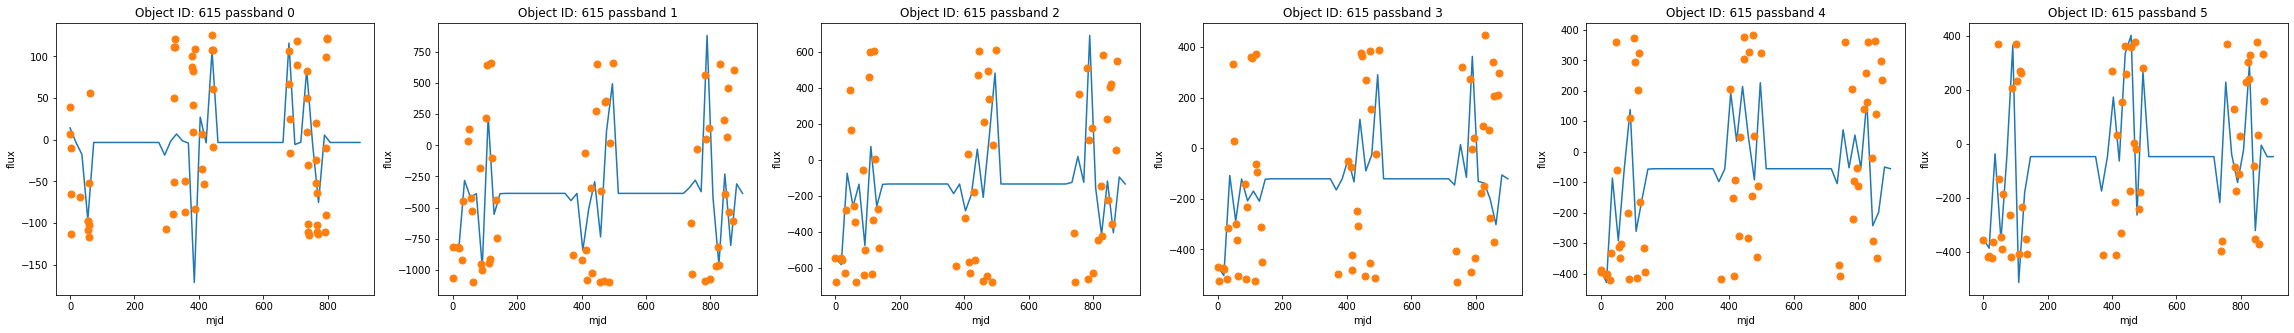

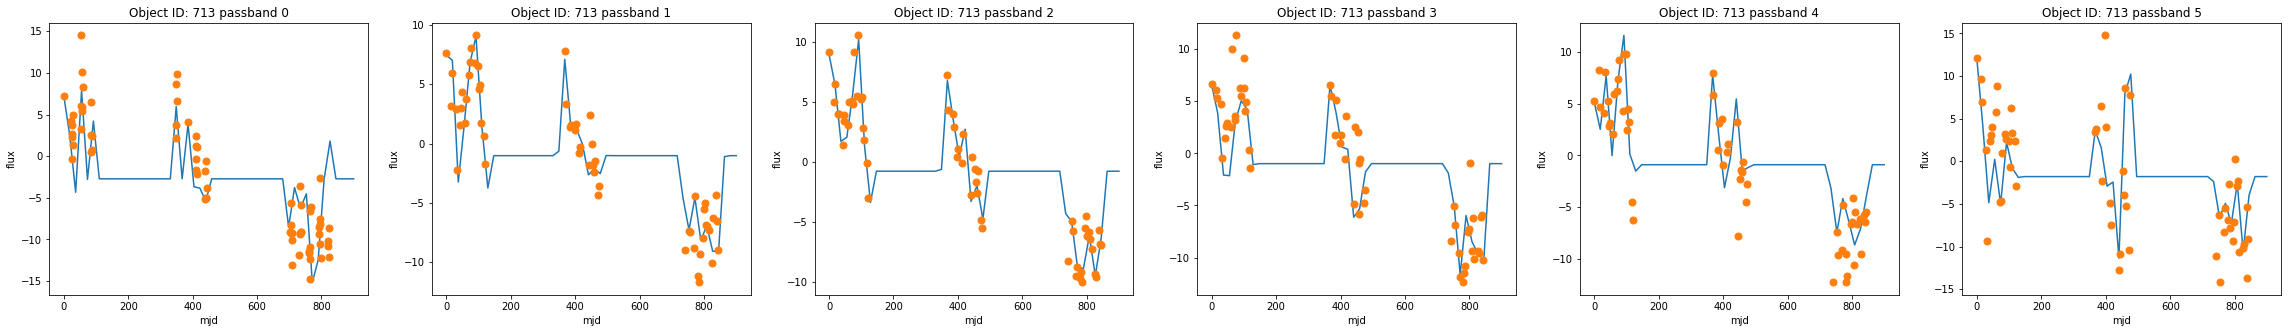

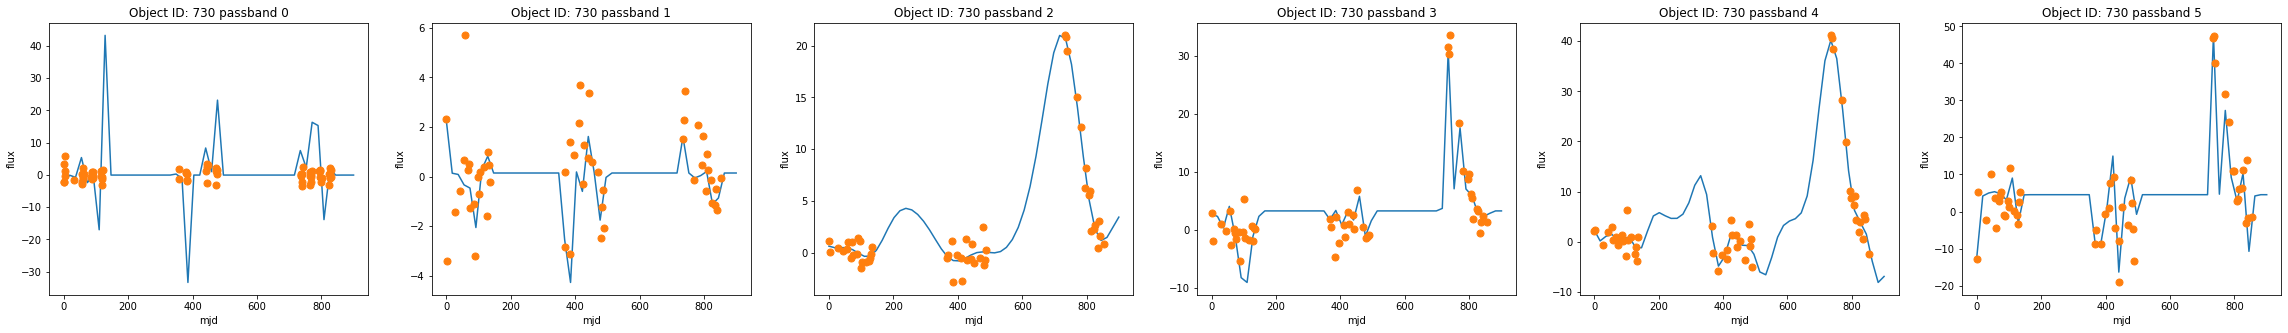

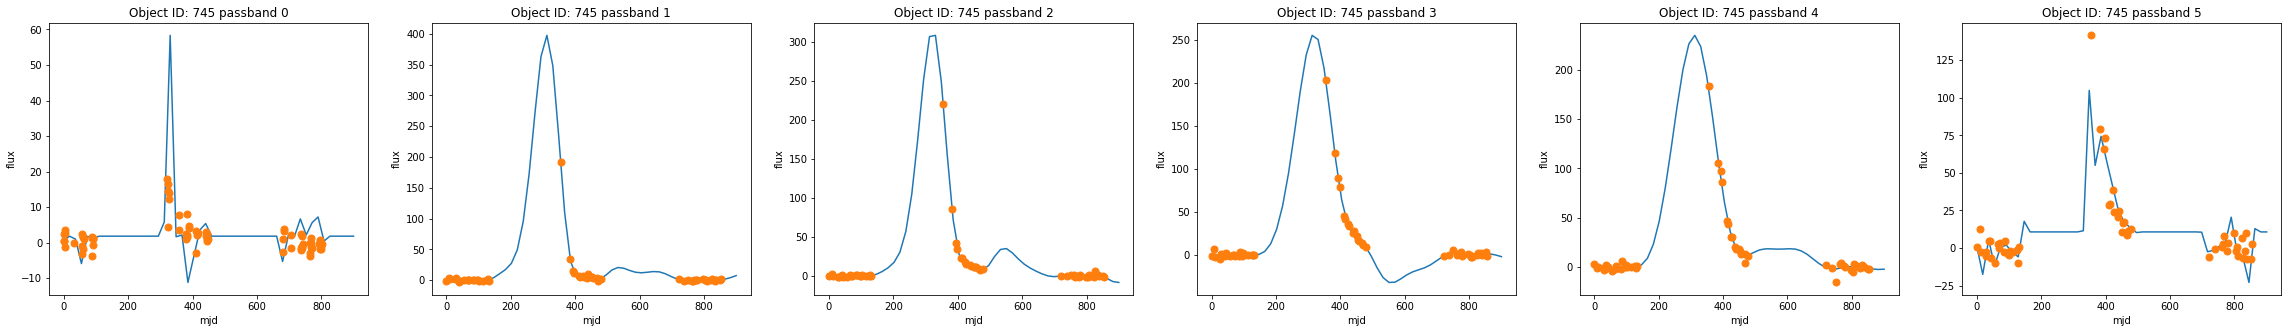

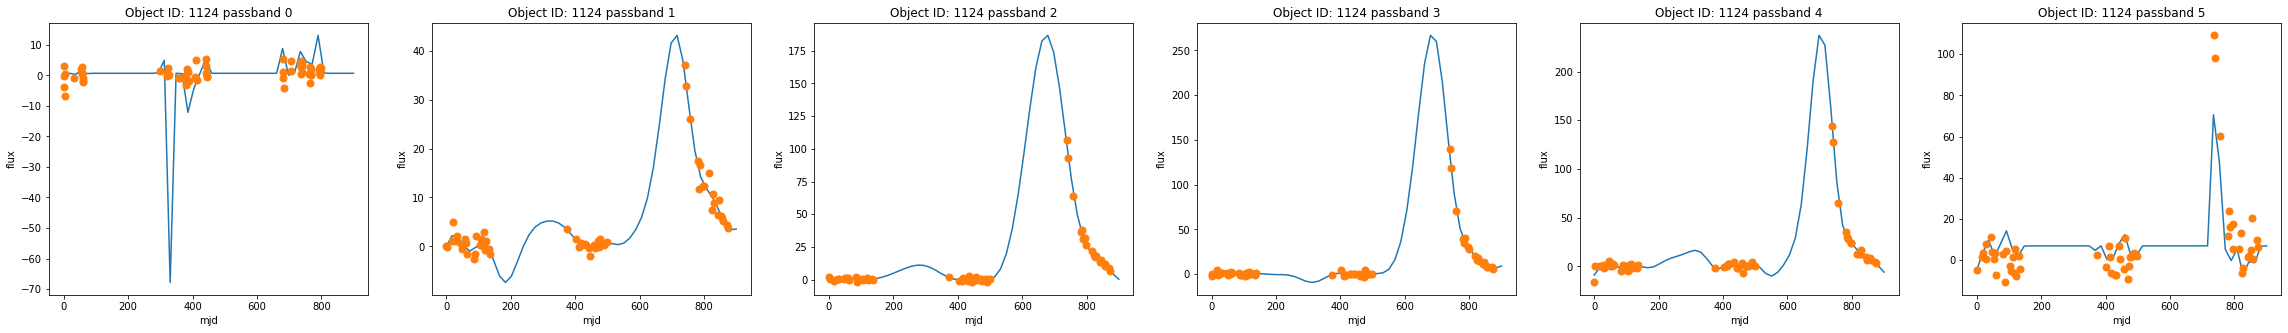

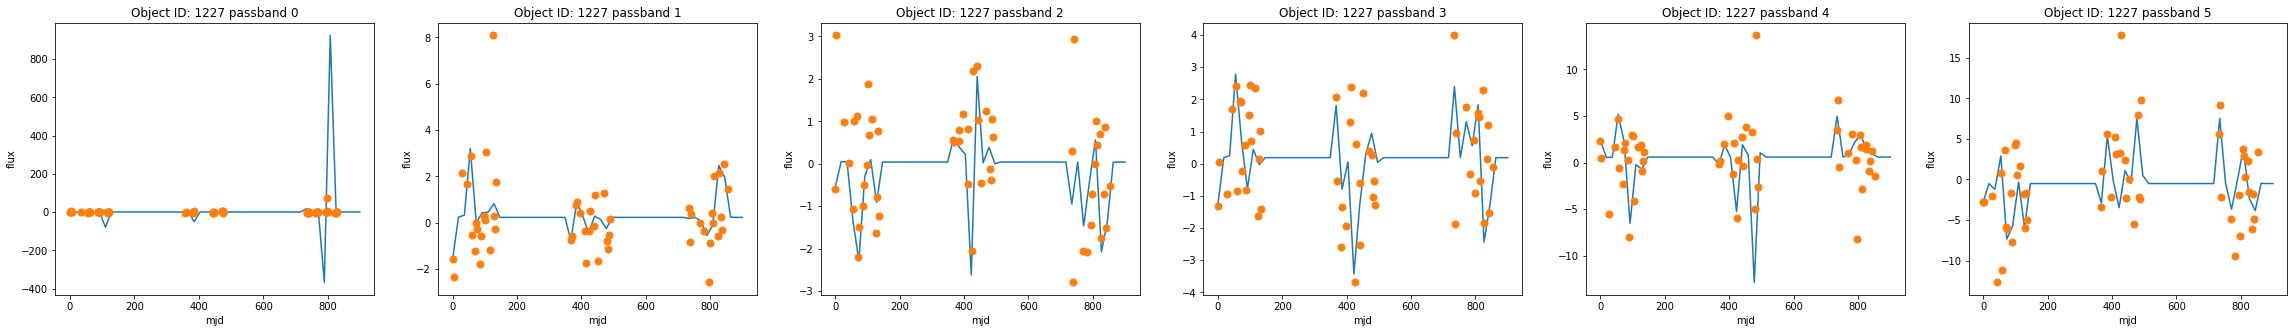

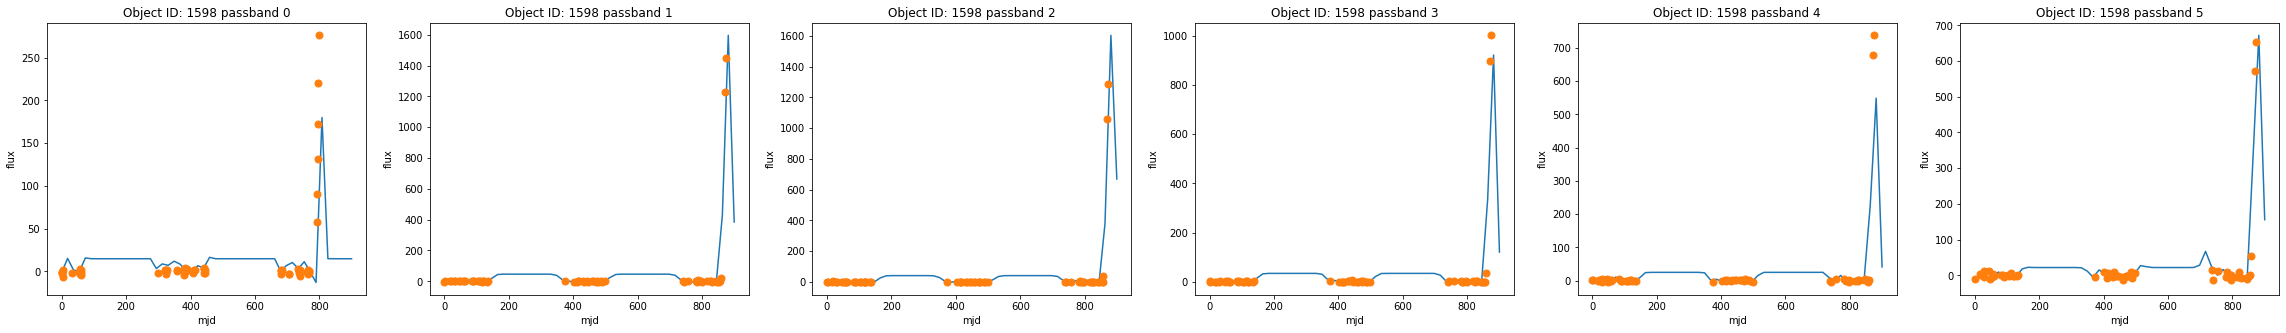

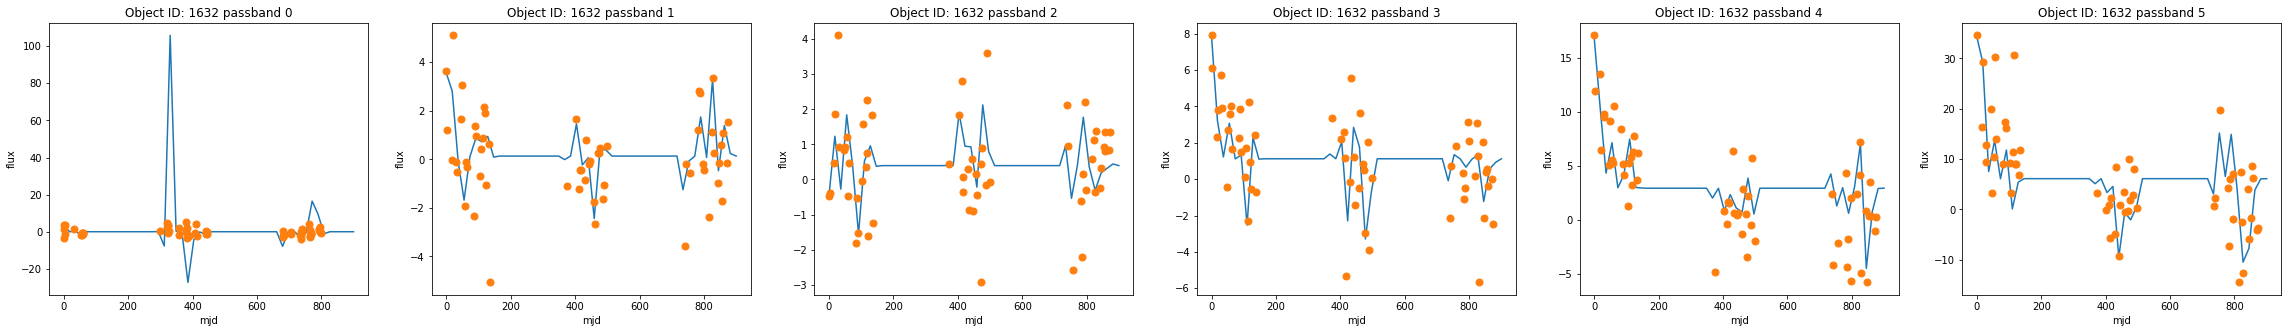

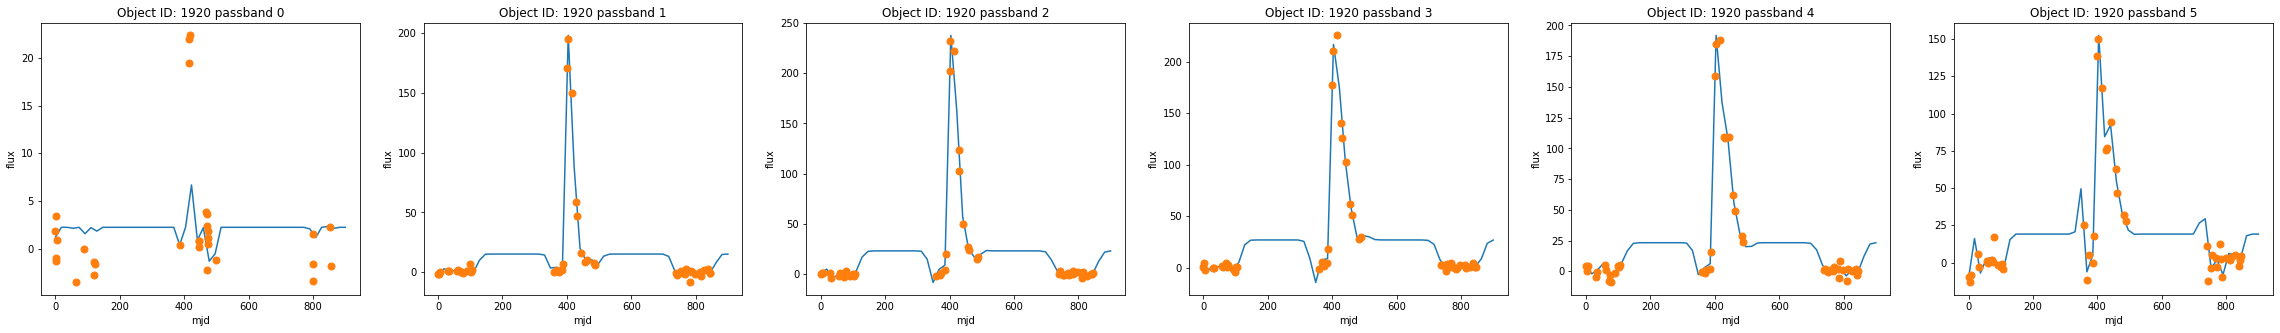

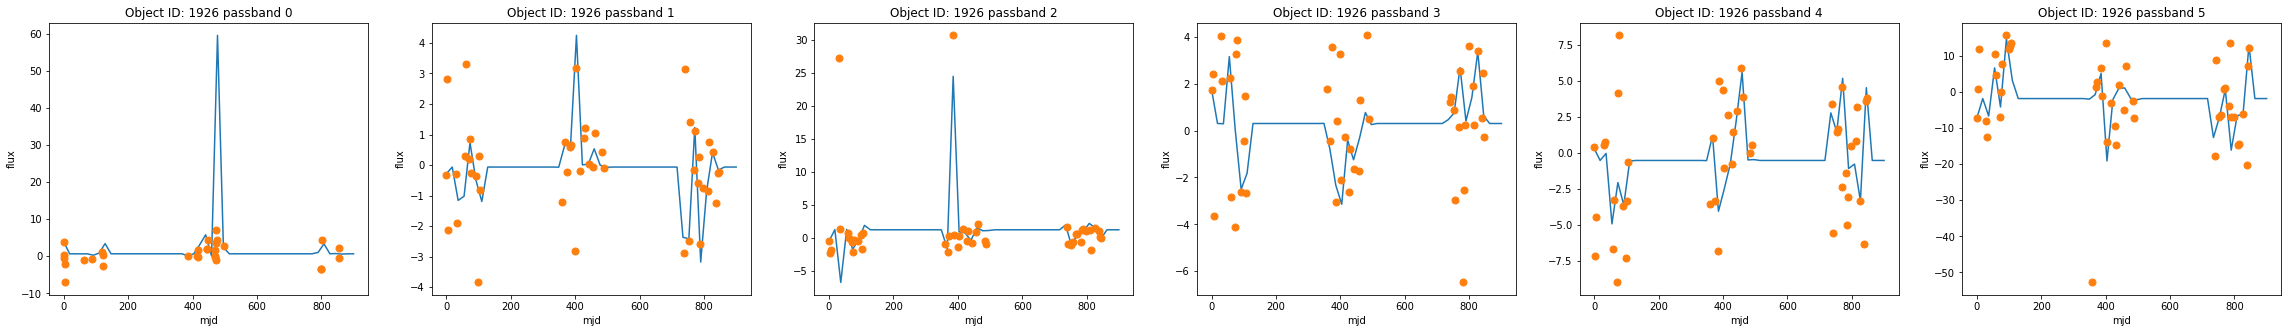

In [115]:
for i, obj in enumerate(list(lcvs.object_id.unique())[:10]):
    fig, ax = plt.subplots(1, 6, figsize=(40, 5))
    for p in range(6):
        mjd = lcvs[lcvs.object_id == obj][lcvs.passband == p]['mjd'].to_numpy()
        mjd = mjd - mjd[0]  # Set initial time to '0'
        flux = lcvs[lcvs.object_id == obj][lcvs.passband == p]['flux'].to_numpy()

        ax[p].plot(mjds[i*6 + p], fluxs[i*6 + p], label='Gaussian process')
        ax[p].errorbar(mjd, flux, fmt='o', markersize=7, label='data')
        ax[p].set_title('Object ID: {0} passband {1}'.format(obj, p))
        ax[p].set_ylabel('flux')
        ax[p].set_xlabel('mjd')
        fig.show();

**Figure 1:** The above figures plot the flux of each passband of the first 10 objects against time. The data points are the actual observations, while the smooth line is the Gaussian Process fit to the data points. The time axis was scaled such that the first time in the series is set to 0, and all times afterwards represent the change from the initial point.

In [0]:
object_ids_adj = object_ids.reshape(object_ids.shape[0] // 6, object_ids.shape[1] * 6).astype(int)
mjds_adj = mjds.reshape(mjds.shape[0] // 6, mjds.shape[1] * 6)
fluxs_adj = fluxs.reshape(fluxs.shape[0] // 6, fluxs.shape[1] * 6)
passbands_adj = passbands.reshape(passbands.shape[0] // 6, passbands.shape[1] * 6)

In [0]:
gp_data = pd.DataFrame(fluxs_adj, index=object_ids_adj[:, 0])
gp_data.to_csv('gp_data.csv')

In [118]:
gp_data = pd.read_csv('gp_data.csv', index_col=0)
gp_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
615,14.205290,-3.254794,-17.594481,-95.853645,-3.22834,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-18.405307,-1.797768,6.926693,-1.294247,-3.943007,-171.094849,27.193005,-3.711958,106.478846,-3.255067,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,-3.254554,115.858911,-5.712001,-3.035003,...,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-174.999023,-47.465714,173.300637,-63.940832,334.708780,401.892939,-263.875601,267.907472,-47.449812,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-47.449847,-217.741797,228.402636,-39.547073,-143.581334,-24.031182,294.075903,-321.548401,-5.085846,-47.711789,-47.449847
713,7.229668,2.502558,-4.332575,7.858706,-2.78769,4.216353,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720473,5.955648,-2.720348,3.846664,-3.673723,-3.837843,-5.406312,-2.720726,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-2.720398,-8.503020,-3.778940,...,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794174,3.591356,1.624504,-2.921820,-2.434583,-11.367664,7.924978,10.227787,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-1.794175,-2.381300,-6.566577,-4.936324,-7.320891,-2.605248,-10.557038,-3.967171,-1.794175,-1.794175,-1.794175
730,-2.173553,-0.104508,-0.729180,5.373764,-2.38155,-0.130487,-16.987469,43.222868,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,0.273233,-1.084017,-33.302099,-0.048084,-0.048078,8.335436,1.014453,23.158839,-0.048078,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048080,-0.048075,...,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.538831,-8.559891,-8.309715,1.134207,14.973735,-16.362624,3.547762,9.282161,-0.757994,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.539396,4.541632,47.572787,4.679201,27.295362,9.240930,2.738468,10.331151,-10.761004,4.197170,4.539396,4.539396
745,0.622941,1.790101,0.959057,-5.925442,1.74626,1.212538,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,5.781772,58.347495,1.635586,2.120086,-11.233893,-3.870690,3.479920,5.364236,1.799429,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,1.797523,-5.325032,2.143570,1.697885,...,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746156,11.504382,104.908780,55.015473,74.285960,57.020417,40.430753,23.875817,16.947488,13.349889,10.302851,10.746010,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746138,10.746132,10.582427,-2.448286,-1.461519,1.226901,3.504546,20.552746,-3.130115,-6.420048,-22.869635,12.926757,10.749742,10.746138
1124,-0.242689,0.656053,0.354396,1.387742,0.56526,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.791380,4.925386,-67.828332,0.646001,0.543900,-12.124328,-4.323038,0.496293,5.359531,0.660843,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,0.660948,8.772855,0.084856,0.681845,...,6.896742,6.896742,6.896742,6.896742,6.896742,6.896742,6.896742,6.896742,6.896742,6.896741,4.748905,6.885143,0.291131,0.882498,7.931248,12.368219,

In [119]:
gp_data.shape

(1000, 300)

# Create and Train the Autencoder

In [0]:
X_train, X_test, y_train, y_test = train_test_split(gp_data, gp_data, test_size=0.25, random_state=667)

In [121]:
X_train.shape

(750, 300)

In [122]:
model = Sequential()
model.add(Dense(300, activation='relu', kernel_initializer='he_uniform', input_dim=300))
model.add(Dense(100, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(300, activation='relu'))

model.compile(optimizer='adamax', loss='mse', metrics=['mae'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_8 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_10 (Dense)             (None, 300)               30300     
Total params: 155,825
Trainable params: 155,825
Non-trainable params: 0
_________________________________________________________________
None


In [123]:
history = model.fit(X_train.values, y_train.values, epochs=1000, batch_size=50, verbose=1)
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

model.save("model.h5")

Epoch 1/1000
750/750 [==============================] - 0s 236us/step - loss: 495582.6835 - mae: 72.2101
Epoch 2/1000
750/750 [==============================] - 0s 92us/step - loss: 486984.1180 - mae: 69.6343
Epoch 3/1000
750/750 [==============================] - 0s 90us/step - loss: 482184.1017 - mae: 69.1357
Epoch 4/1000
750/750 [==============================] - 0s 85us/step - loss: 477914.7913 - mae: 68.7273
Epoch 5/1000
750/750 [==============================] - 0s 85us/step - loss: 473980.1945 - mae: 68.6068
Epoch 6/1000
750/750 [==============================] - 0s 97us/step - loss: 469103.4019 - mae: 68.3739
Epoch 7/1000
750/750 [==============================] - 0s 86us/step - loss: 464262.3014 - mae: 68.1813
Epoch 8/1000
750/750 [==============================] - 0s 101us/step - loss: 459872.7995 - mae: 68.1839
Epoch 9/1000
750/750 [==============================] - 0s 93us/step - loss: 453241.6114 - mae: 67.9572
Epoch 10/1000
750/750 [==============================] - 0s 79

In [0]:
history = pickle.load(open('/trainHistoryDict', 'rb'))
model = keras.models.load_model('model.h5')

# Model Validation

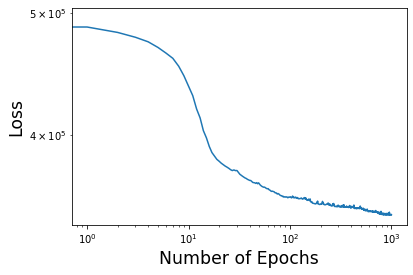

In [126]:
plt.plot(np.array(history.history['loss']))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Epochs', fontsize='xx-large')
plt.ylabel('Loss', fontsize='xx-large');

In [0]:
y_pred = model.predict(X_test)

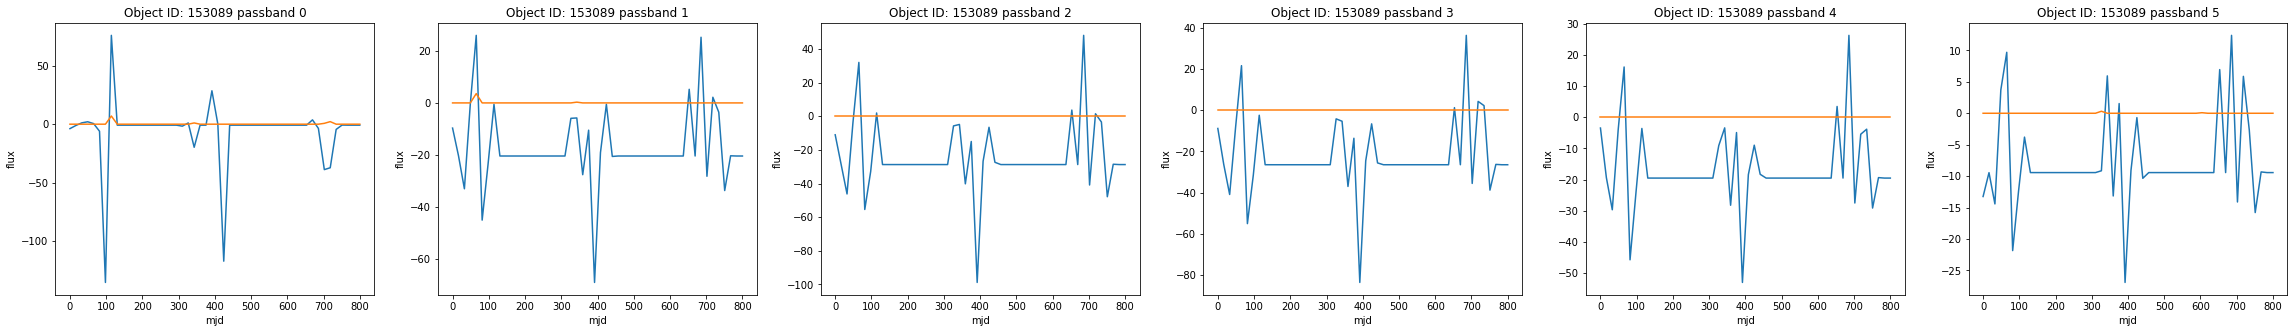

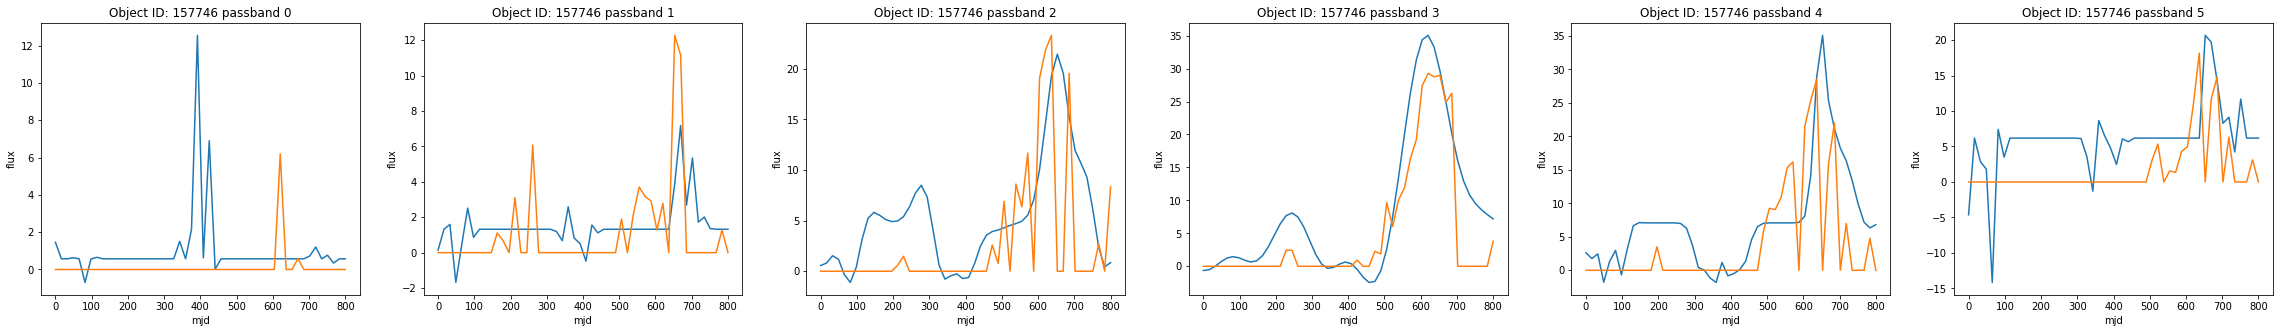

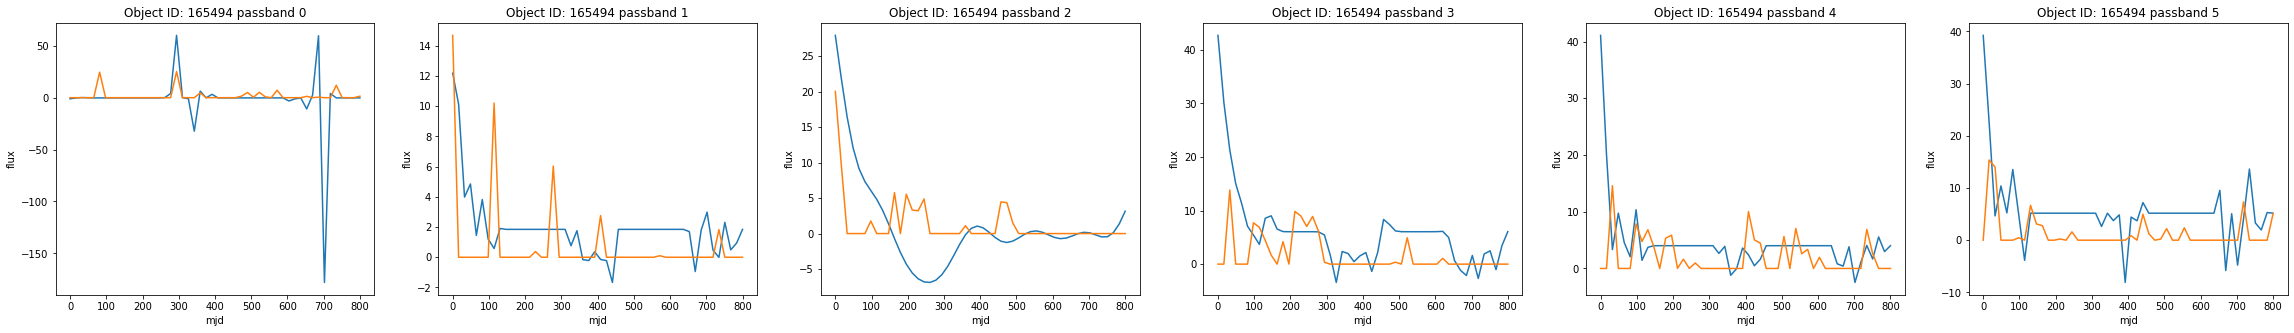

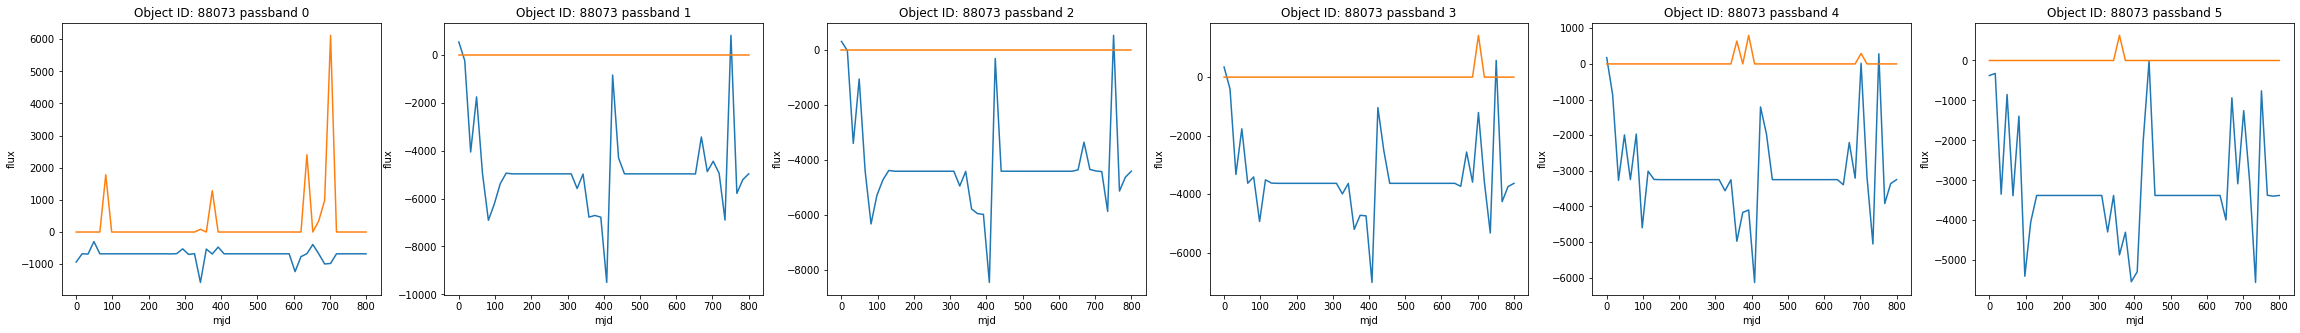

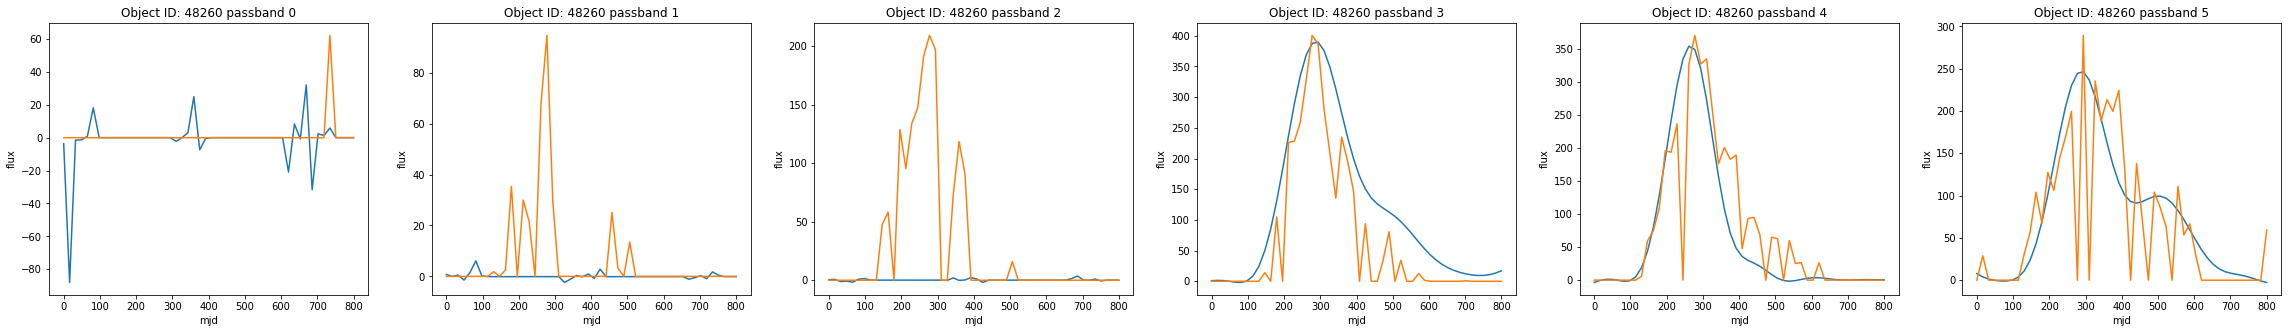

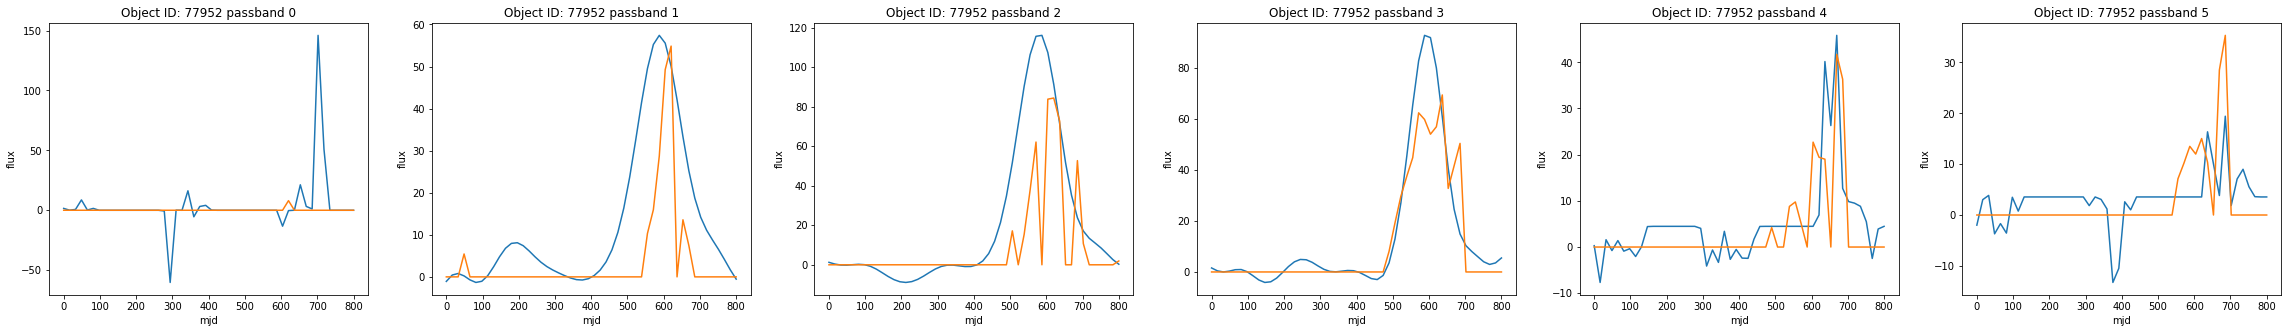

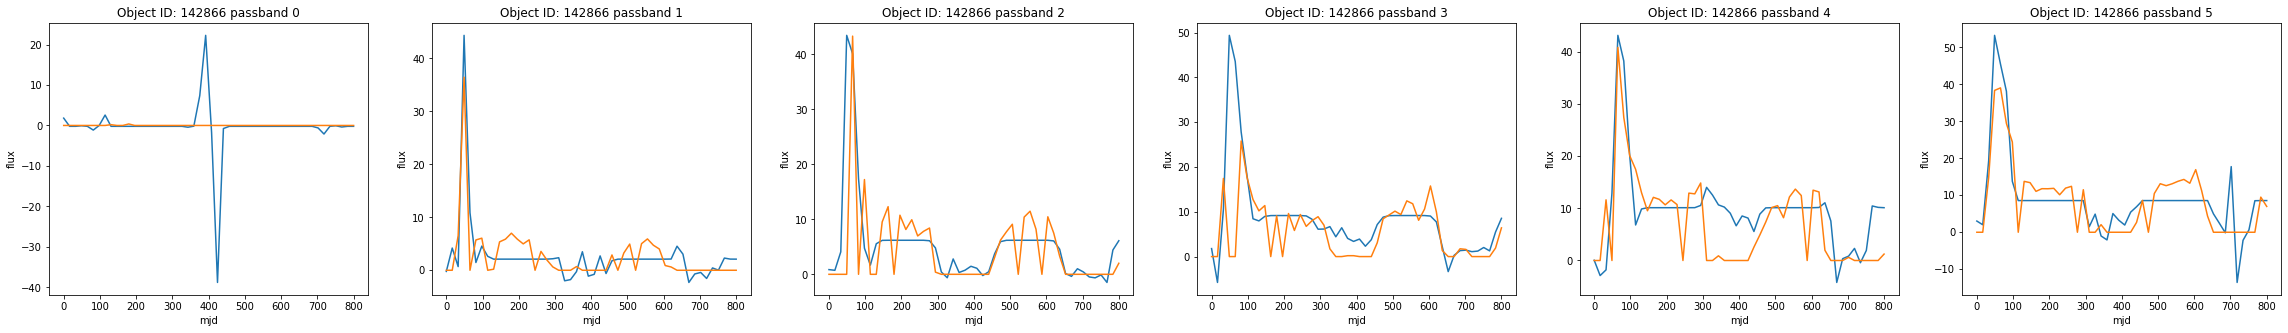

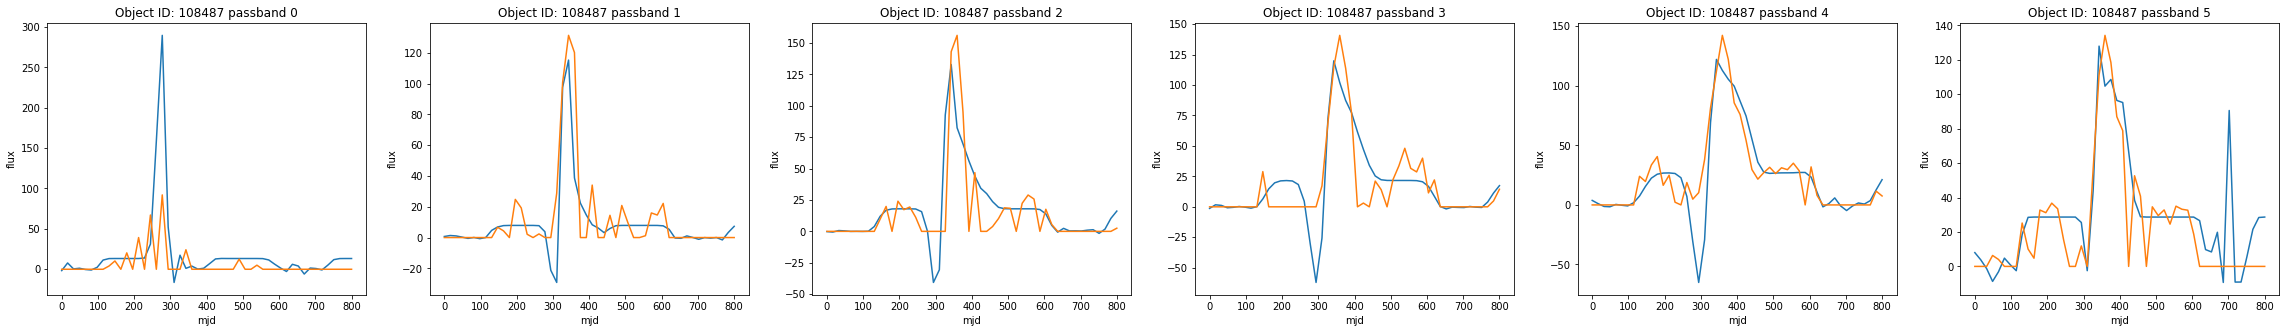

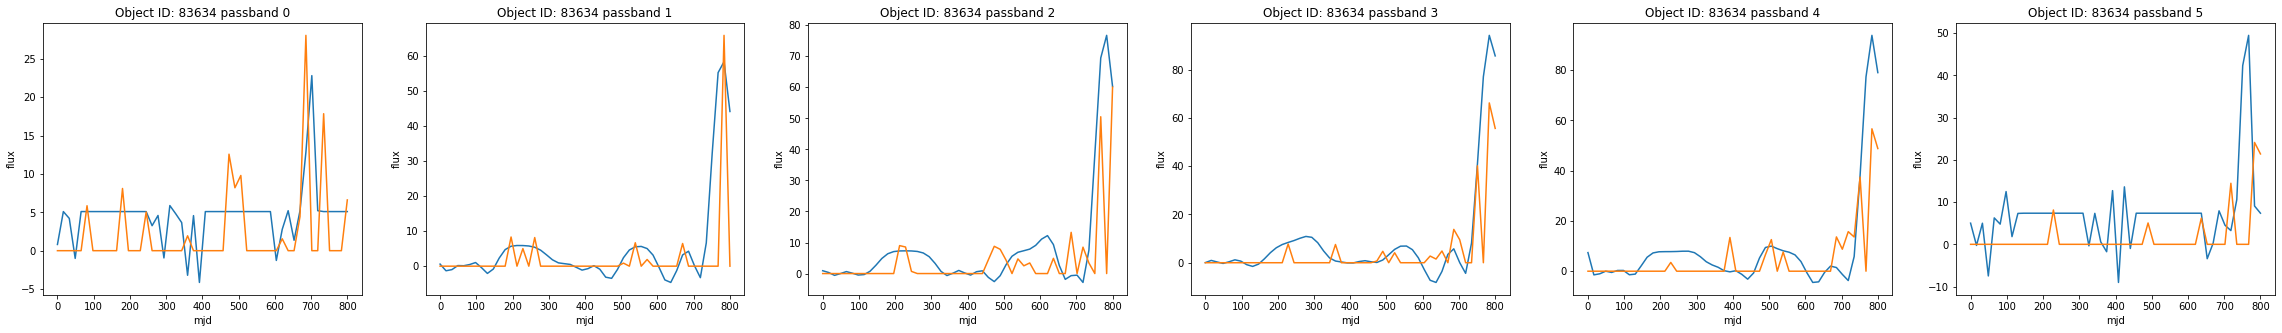

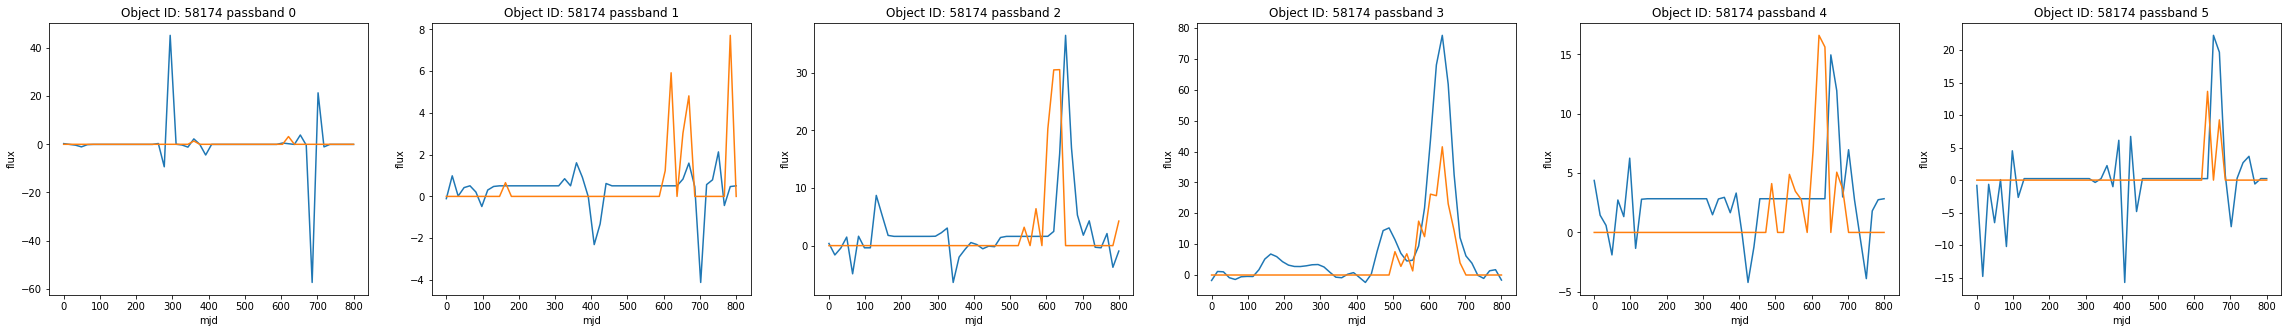

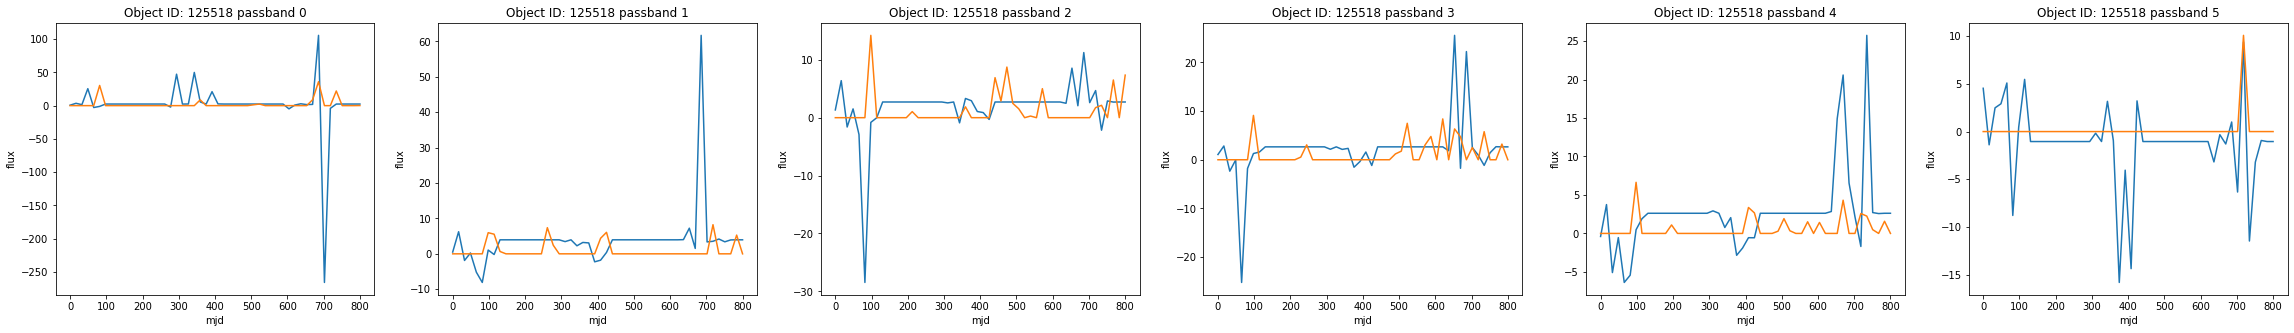

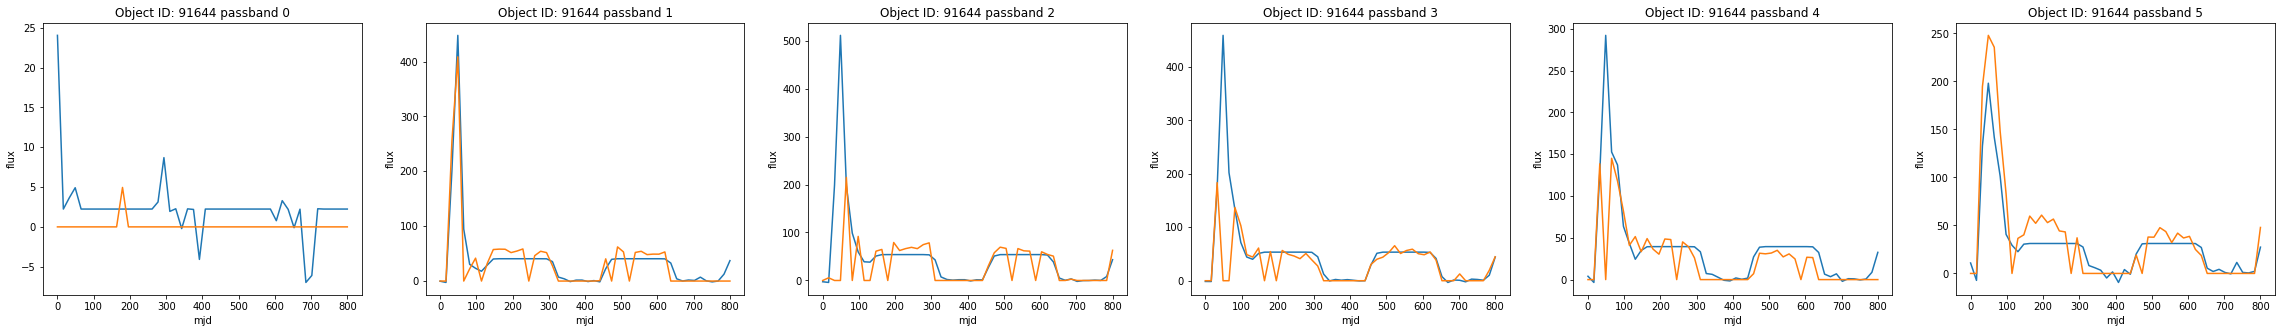

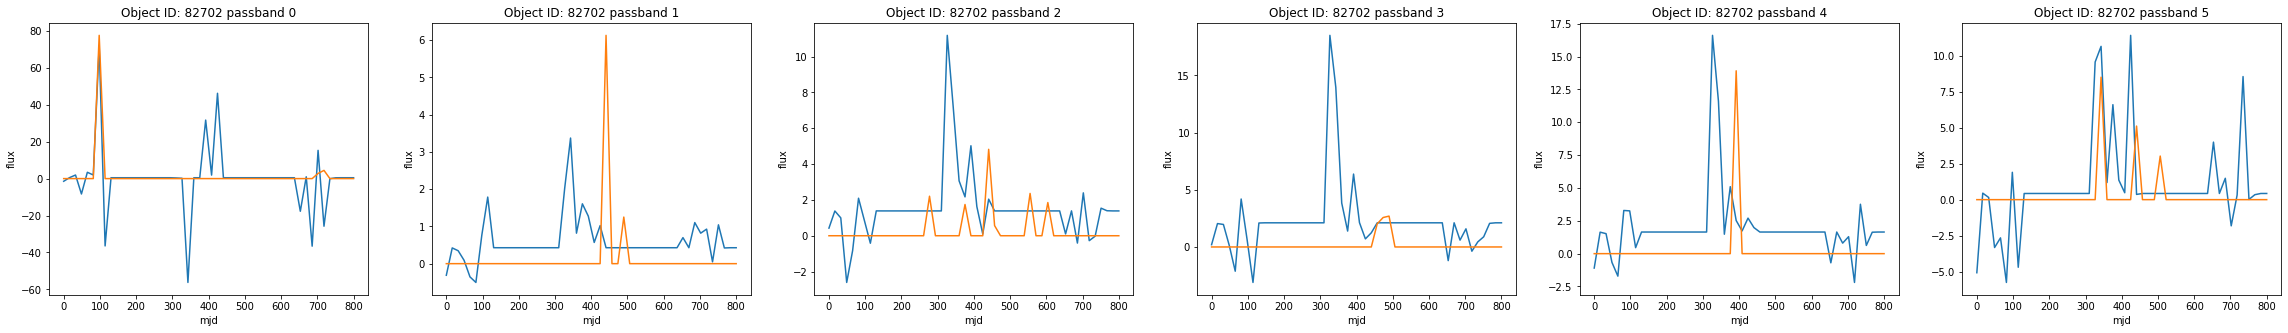

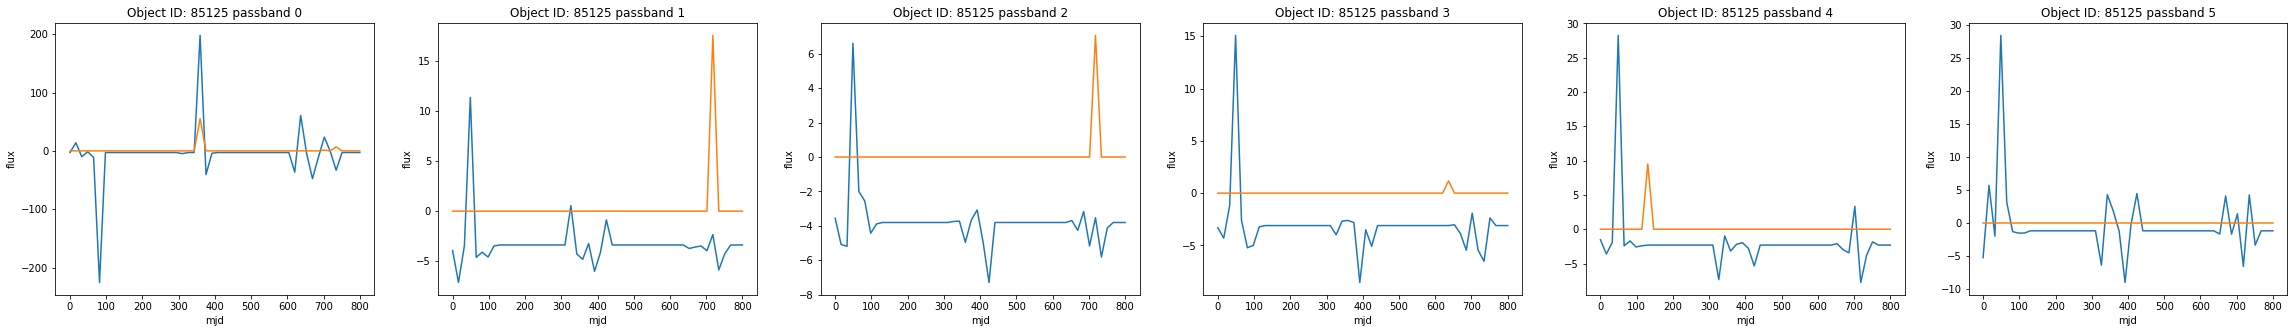

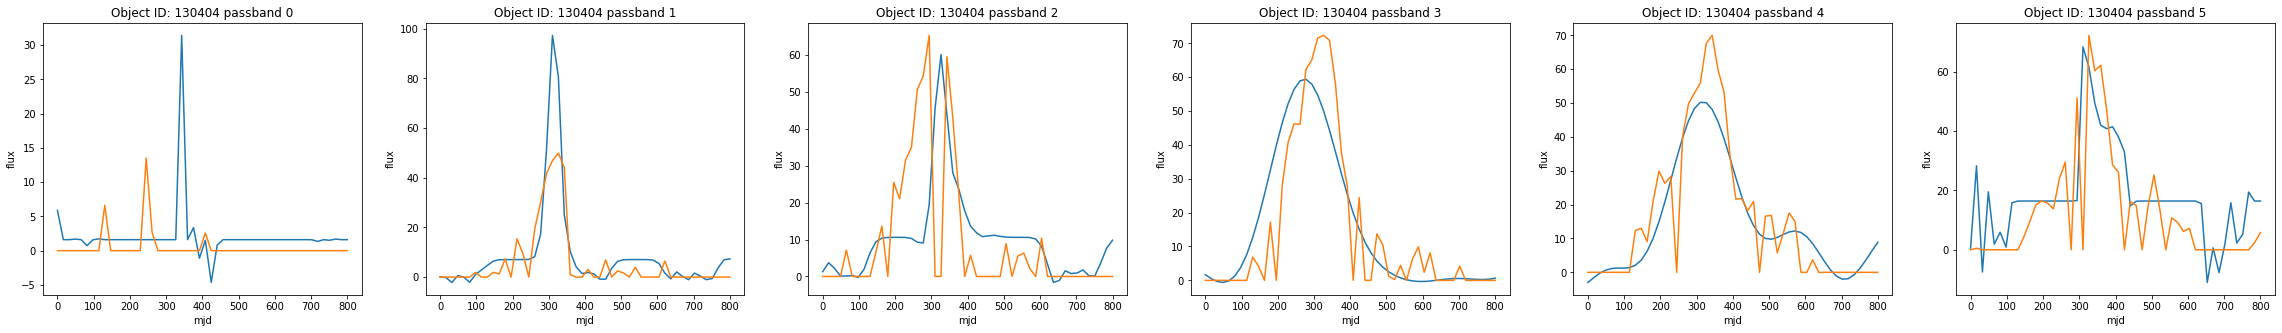

In [129]:
for i in range(len(X_test))[:15]:
    fig, ax = plt.subplots(1, 6, figsize=(40, 5))
    for p in range(6):
        test_mjds = np.linspace(0, 800)
        orig = X_test.values[i].reshape(6, 50)
        pred = y_pred[i].reshape(6, 50)

        ax[p].plot(test_mjds, orig[p], label='original series')
        ax[p].plot(test_mjds, pred[p], label='re-created series')

        ax[p].set_title('Object ID: {0} passband {1}'.format(X_test.index[i], p))
        ax[p].set_ylabel('flux')
        ax[p].set_xlabel('mjd')
    fig.show();

# Extract Bottleneck Values

In [143]:
# Create encoder to extract the bottleneck features from the model
encoder = Model(model.input, model.layers[-3].output)
enc_preds = encoder.predict(fluxs_adj)
enc_preds.shape

(1000, 25)

Note that now each observation (which originally contained 300 features) now has been represented by only 10.

In [144]:
enc_features = pd.DataFrame(enc_preds, columns=['enc{0}'.format(i) for i in range(enc_preds.shape[1])])
enc_features.head()

,enc0,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10,enc11,enc12,enc13,enc14,enc15,enc16,enc17,enc18,enc19,enc20,enc21,enc22,enc23,enc24
0,0.00000,0.000000,552.567078,245.898117,0.0,1246.837891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.593163,1780.788696,890.972656,625.039124,0.0,1600.491455,0.000000,1695.856934,0.000000,1477.797974,0.000000,0.000000,431.762512
1,0.00000,0.921890,0.000000,5.532236,0.0,9.409441,0.000000,19.157675,0.000000,0.000000,0.000000,11.197996,6.226247,0.000000,0.000000,2.862632,0.0,0.000000,13.900074,0.000000,1.394007,2.785827,9.868140,0.000000,0.000000
2,4.51601,0.000000,27.486546,50.637062,0.0,63.007896,118.058983,53.344048,37.126629,77.064095,83.951790,56.844837,0.000000,25.571154,60.197075,3.209801,0.0,55.557400,21.463974,44.819309,91.678276,48.253281,4.606825,1.807638,21.804369
3,0.00000,577.859009,595.876160,0.000000,0.0,390.710907,138.661194,1037.385864,92.107033,588.944885,785.368958,170.847839,575.822937,389.601807,0.000000,277.086273,0.0,87.274796,734.596375,293.515015,366.478577,85.677261,859.686096,155.527466,0.000000
4,0.00000,26.062822,78.279869,539.301147,0.0,217.436966,740.868225,0.000000,339.793152,134.291382,610.654724,895.133667,44.123592,76.115013,275.484924,0.000000,0.0,439.156525,293.183838,414.083130,829.674194,88.527542,0.000000,0.000000,224.780365


# Combine the encoded values with the extracted lightcurve features

We will now combine these predicted values with the features we extraced in homework 6.

In [145]:
# Merge the encoded features with the observations from homework 6
oldfeatures = pd.read_csv('allfeatures.csv', index_col=0)[:len(enc_preds)]
allfeatures = oldfeatures.merge(enc_features, on=oldfeatures.index).drop(columns='key_0')
allfeatures.head()

,"(0, 'stds')","(0, 'kurt')","(0, 'median')","(0, 'slopes')","(0, 'intercepts')","(0, 'll2')","(1, 'stds')","(1, 'kurt')","(1, 'median')","(1, 'slopes')","(1, 'intercepts')","(1, 'll2')","(2, 'stds')","(2, 'kurt')","(2, 'median')","(2, 'slopes')","(2, 'intercepts')","(2, 'll2')","(3, 'stds')","(3, 'kurt')","(3, 'median')","(3, 'slopes')","(3, 'intercepts')","(3, 'll2')","(4, 'stds')","(4, 'kurt')","(4, 'median')","(4, 'slopes')","(4, 'intercepts')","(4, 'll2')","(5, 'stds')","(5, 'kurt')","(5, 'median')","(5, 'slopes')","(5, 'intercepts')","(5, 'll2')",decl,ddf,target,enc0,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10,enc11,enc12,enc13,enc14,enc15,enc16,enc17,enc18,enc19,enc20,enc21,enc22,enc23,enc24
0,83.944735,7.433032e+07,-0.080537,0.005676,-0.175947,-84.013092,601.787302,2.215166e+11,-0.170090,0.014032,-0.399902,-80.867915,455.121346,6.659406e+10,-0.289021,0.017676,-0.503760,-80.092803,335.425053,1.919999e+10,-0.122434,0.020475,-0.583524,-79.226482,291.803449,1.036570e+10,-0.163078,0.022343,-0.636786,-78.160027,294.779522,1.049535e+10,-0.129163,0.021319,-0.596932,-76.917754,-61.943836,1,92,0.00000,0.000000,552.567078,245.898117,0.0,1246.837891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.593163,1780.788696,890.972656,625.039124,0.0,1600.491455,0.000000,1695.856934,0.000000,1477.797974,0.000000,0.000000,431.762512
1,7.113509,4.907398e+03,-0.052914,-0.041433,1.429423,-45.801483,5.712334,1.944373e+03,0.080189,-0.051648,1.420320,-36.052358,5.770738,1.935955e+03,0.117188,-0.053887,1.481892,-34.410798,6.450413,3.091660e+03,0.141552,-0.050983,1.402038,-38.701863,6.406989,2.938985e+03,0.016870,-0.050464,1.387765,-44.424807,7.094073,5.294322e+03,-0.094281,-0.037903,1.042343,-65.167686,-27.784405,1,88,0.00000,0.921890,0.000000,5.532236,0.0,9.409441,0.000000,19.157675,0.000000,0.000000,0.000000,11.197996,6.226247,0.000000,0.000000,2.862632,0.0,0.000000,13.900074,0.000000,1.394007,2.785827,9.868140,0.000000,0.000000
2,1.828872,3.655013e+01,0.039463,-0.001798,0.063840,-101.249926,1.807229,3.870188e+01,0.016754,0.003167,-0.080770,-72.910038,5.559483,6.926529e+03,-0.343392,0.026905,-0.686084,-63.777334,8.191987,4.048490e+04,-0.314425,0.024491,-0.624531,-66.369632,10.710344,1.060595e+05,-0.308522,0.022552,-0.563811,-65.239486,13.332758,1.860606e+05,-0.149763,0.019612,-0.490299,-66.518080,-6.579593,1,42,4.51601,0.000000,27.486546,50.637062,0.0,63.007896,118.058983,53.344048,37.126629,77.064095,83.951790,56.844837,0.000000,25.571154,60.197075,3.209801,0.0,55.557400,21.463974,44.819309,91.678276,48.253281,4.606825,1.807638,21.804369
3,4.374445,2.575248e+03,-0.169349,-0.013089,0.464675,-88.423048,25.964659,2.162844e+07,-0.185994,-0.003826,0.105205,-76.313623,31.957997,3.606109e+07,-0.290606,-0.003878,0.106641,-72.846380,34.967698,2.575691e+07,-0.373246,-0.003931,0.108112,-67.105516,33.069053,1.781661e+07,-0.358773,-0.004774,0.131296,-67.067827,26.060130,6.203072e+06,-0.306851,-0.002816,0.076043,-64.783463,-45.586655,1,90,0.00000,577.859009,595.876160,0.000000,0.0,390.710907,138.661194,1037.385864,92.107033,588.944885,785.368958,170.847839,575.822937,389.601807,0.000000,277.086273,0.0,87.274796,734.596375,293.515015,366.478577,85.677261,859.686096,155.527466,0.000000
4,2.360084,1.101222e+02,-0.033864,0.017117,-0.530614,-84.959510,8.107525,3.545471e+04,-0.429236,0.028666,-0.816982,-67.527468,21.319854,2.468546e+06,-0.438785,0.025384,-0.723449,-71.247906,26.270649,7.271993e+06,-0.383411,0.021342,-0.608237,-74.498916,26.865913,9.005039e+06,-0.303771,0.019736,-0.562470,-75.898716,21.434627,3.279413e+06,-0.229697,0.015555,-0.435534,-76.526495,-63.823658,1,90,0.00000,26.062822,78.279869,539.301147,0.0,217.436966,740.868225,0.000000,339.793152,134.291382,610.654724,895.133667,44.123592,76.115013,275.484924,0.000000,0.0,439.156525,293.183838,414.083130,829.674194,88.527542,0.000000,0.000000,224.780365


In [0]:
# Deal with missing data
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).iloc[:, 1:]
X = allfeatures.drop(columns='target').values
y = allfeatures.loc[:,'target'].values

In [0]:
X_scaled = preprocessing.scale(X)

# Classifiy the Light Curves

Using the bottlenecked values generated by the autoencoder, as well as the object features used in the PLAsTiCC challenge assignment, I will classify the light curves

In [0]:
metadata = pd.read_csv('training_set_metadata.csv', index_col=0)[:len(enc_preds)]

Xddf = X[metadata.ddf == 1]
Xnormal = X[metadata.ddf == 0]

In [0]:
X_trainddf, X_testddf, y_trainddf, y_testddf = train_test_split(Xddf, yddf, random_state=667)

In [0]:
clfddf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5).fit(X_trainddf, y_trainddf)

In [155]:
ddf_score_rf = clfddf.score(X_testddf, y_testddf)

print('\033[1mRandom Forest Classification Scores (for DDF)\033[0m')
print('Homework 6 (no encoded features): 0.6654\nWith encoded features:            {0:.4f}'.format(ddf_score_rf))

Random Forest Classification Scores (for DDF)
Homework 6 (no encoded features): 0.6654
With encoded features:            0.6760


It is important to note that in homework 6, there were over 7,800 light curves to classify. In this assignment we did not use all observations because doing so would require too much computing time.

Normalized confusion matrix


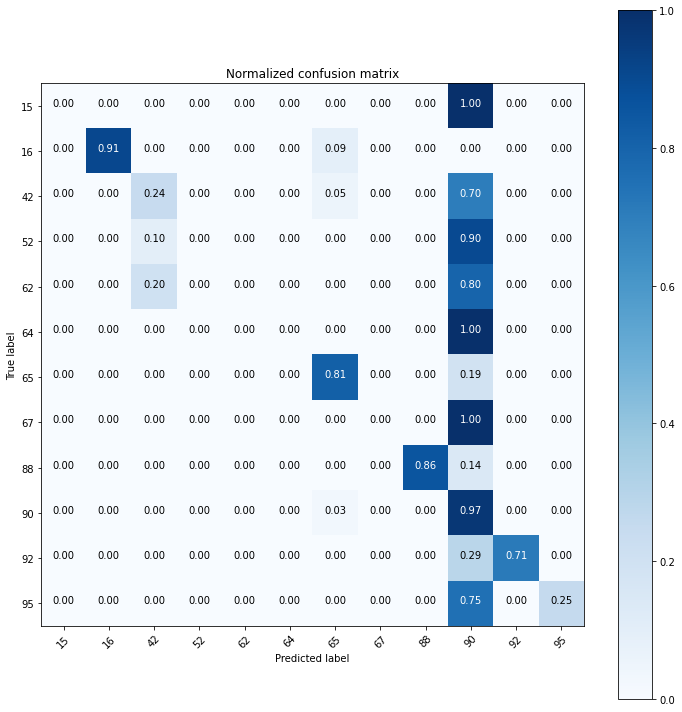

In [159]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testddf, clfddf.predict(X_testddf))
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=["%d"%i for i in np.unique(y_testddf)], normalize=True,
                      title='Normalized confusion matrix')

plt.show()